In [4]:
pip install pymorphy2

  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=86b6a76eb89633d86494367cbb6595350f2d6783119a3f0a336e0a8eced3a410
  Stored in directory: c:\users\chizm\appdata\local\pip\cache\wheels\70\4a\46\1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Successfully built docopt
Note: you may need to restart the kernel to use updated packages.


In [17]:
import numpy as np
import pandas as pd

import json
import bz2

import regex

from bs4 import BeautifulSoup

import gensim
from gensim.models import word2vec 
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.models import LdaMulticore
from gensim.models import lsimodel

import nltk
import nltk.data
from nltk.tokenize import sent_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
nltk.download('punkt')

from tqdm import tqdm
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification
from sklearn.metrics import classification_report
from scipy.sparse import csr_matrix

from sklearn.pipeline import Pipeline



%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chizm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:09, 2873.69it/s]


In [7]:
responses[10]

{'city': 'г. Москва',
 'rating_not_checked': False,
 'title': 'Повесили кредит',
 'num_comments': 15,
 'bank_license': 'лицензия № 1326',
 'author': 'Юля2015',
 'bank_name': 'Альфа-Банк',
 'datetime': '2015-06-05 12:24:28',
 'text': 'Вот даже и засомневалась, какую ставить оценку... в итоге пишу без неё. Являюсь клиентом Альфа-Банка с 2012 года. Взяла тогда кредит наличными. Погашаю его, в т.ч. частично-досрочными суммами. Потом мне выпустили кредитную карту, на весьма выгодных условиях. Ей я тоже пользуюсь и вношу платежи. И вот на днях звонит мне девушка и говорит, что у меня просрочка. Я, оставаясь с ней на связи, лезу в яндекс.деньги и проверяю: карта и кредит оплачены. И тут она мне выдаёт: "У Вас в нашем банке 3(!) кредитных продукта! В апреле 2014 Вы брали потребительский кредит на продукт". Я в шоке, т.к. никаких кредитов в Альфе я больше не брала. Мне говорят, что нужно прийти в отделение и написать претензию. Кладу трубку. Вспоминаю: в апреле прошлого года я подавала заявку н

In [8]:
def json_to_pd(review):
    city = []
    rating_not_checked = []
    title = []
    num_comments = []
    bank_license = []
    author = []
    bank_name = []
    datetime = []
    text = []
    rating_grade = []
    
    for rec in review:
        city.append(rec['city'])
        rating_not_checked.append(rec['rating_not_checked'])
        title.append(rec['title'])
        num_comments.append(rec['num_comments'])
        bank_license.append(rec['bank_license'])
        author.append(rec['author'])
        bank_name.append(rec['bank_name'])
        datetime.append(rec['datetime'])
        text.append(rec['text'])
        rating_grade.append(rec['rating_grade'])
    return pd.DataFrame(
        {
            'city': city,
            'rating_not_checked': rating_not_checked,
            'title': title,
            'num_comments': num_comments,
            'bank_license': bank_license,
            'author': author,
            'bank_name': bank_name,
            'datetime': datetime,
            'text': text,
            'rating_grade': rating_grade
            
        }
    )

In [9]:
df = json_to_pd(responses)

In [10]:
df.sample(5)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
152985,None,False,Нормальный банк,0,лицензия № 2291,Анна,ИМПЭКСБанк,2005-05-25 20:13:00,"Получила народный кредит, решения ждала 2 неде...",5.0
12814,г. Москва,False,Неправомерная комиссия,1,лицензия № 1481,vik3,Сбербанк России,2015-02-20 18:18:00,"20 фев 2015 с кредитной карты было снято 400р,...",NaN
145932,None,False,Ипотечный кредит,0,лицензия № 2216,vladim,Банк Интеза,2007-11-01 13:49:00,7 октября обратился в банк КМБ по совету друзе...,1.0
149760,None,False,"""Индивидуальный подход""",2,лицензия № 2557,grad76,Ситибанк,2006-06-16 02:00:00,Я и мой друг стали клиентами этого банка совсе...,1.0
77195,г. Самара,False,Некомпетентные сотрудники,0,лицензия № 1481,Czech711,Сбербанк России,2013-08-08 17:09:00,"Обращаюсь от лица клиентов, с которыми довелос...",NaN


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city                138325 non-null  object 
 1   rating_not_checked  153499 non-null  bool   
 2   title               153499 non-null  object 
 3   num_comments        153499 non-null  int64  
 4   bank_license        153498 non-null  object 
 5   author              153479 non-null  object 
 6   bank_name           153499 non-null  object 
 7   datetime            153499 non-null  object 
 8   text                153499 non-null  object 
 9   rating_grade        88658 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


In [12]:
# отфильтруем только записи, содержащие ненулевой рейтинг
df_score = df[(df['rating_grade'].isna() == False) & (df['text'].isna() == False)].reset_index()[['text', 'rating_grade']]

In [13]:
df_score.sample(5)

,text,rating_grade
25627,Почитайте мою историю общения с Бинбанком и ва...,1.0
51617,Моя жена вчера открыла вклад в данном финучреж...,4.0
67214,Вчера сняв долларовый депозит в филиале банка ...,1.0
42422,Взяла кредит в данном банке 2-й раз (на покупк...,5.0
5811,Добрый день! В декабре 21.12.2014 писал жалобу...,1.0


In [14]:
def review_to_wordlist(review, lemmatizer, remove_stopwords=False):
    # убираем ссылки
    review_text = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", " ", review)
    # достаем сам текст
    # review_text = BeautifulSoup(review_text, "lxml").get_text()
    # оставляем только буквенные символы
    review_text = re.sub("[^а-яА-ЯёЁ]"," ", review_text)
    # приводим к нижнему регистру и разбиваем на слова по символу пробела
    words = review_text.lower().split()
    if remove_stopwords: # убираем стоп-слова
        russian_stopwords = stopwords.words("russian")
        #stops = stopwords.words("english")
        words = [w for w in words if not w in russian_stopwords]
    if lemmatizer:
        return([lemmatizer.parse(word)[0].normal_form for word in words])
    else:
        return words
    
def review_to_sentences(review, tokenizer, lemmatizer = None, remove_stopwords=False):
    # разбиваем обзор на предложения
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    # применяем предыдущую функцию к каждому предложению
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(review_to_wordlist(raw_sentence, lemmatizer, remove_stopwords))
    return sentences

In [18]:
tokenizer = nltk.data.load('tokenizers/punkt/russian.pickle')
lemmatizer = MorphAnalyzer()

In [19]:
sentences_no_lemm = []  
print('Parsing sentences...')
for review in tqdm(df['text']):
    sentences_no_lemm += review_to_sentences(review, tokenizer)

Parsing sentences...


100%|████████████████████████████████████████████████████████████████████████| 153499/153499 [02:03<00:00, 1241.31it/s]


In [20]:
sentences = []  
print('Parsing sentences...')
for review in tqdm(df['text']):
    sentences += review_to_sentences(review, tokenizer, lemmatizer)

Parsing sentences...


  6%|████▎                                                                     | 8980/153499 [09:45<3:10:29, 12.64it/s]

100%|████████████████████████████████████████████████████████████████████████| 153499/153499 [2:31:40<00:00, 16.87it/s]


In [21]:
sentences[0:2]

[['добрый', 'день'],
 ['я',
  'не',
  'являться',
  'клиент',
  'банк',
  'и',
  'поручитель',
  'по',
  'кредитный',
  'договор',
  'а',
  'также',
  'не',
  'являться',
  'какой',
  'либо',
  'другой',
  'лицо',
  'письменно',
  'оформить',
  'отношение',
  'с',
  'банк',
  'по',
  'повод',
  'урегулирование',
  'чей',
  'либо',
  'задолженность']]

In [22]:
with open('text_banki_lem.txt', 'w') as f:
    for s in sentences:
        f.write(' '.join(s))
        f.write('\n')

In [23]:
import csv
sentences = []
with open('text_banki_lem.txt', 'r', newline='') as csvfile:
    r = csv.reader(csvfile, delimiter=' ')
    sentences.append(list(r))
sentences = sentences[0]

In [24]:
sentences[0:2]

[['добрый', 'день'],
 ['я',
  'не',
  'являться',
  'клиент',
  'банк',
  'и',
  'поручитель',
  'по',
  'кредитный',
  'договор',
  'а',
  'также',
  'не',
  'являться',
  'какой',
  'либо',
  'другой',
  'лицо',
  'письменно',
  'оформить',
  'отношение',
  'с',
  'банк',
  'по',
  'повод',
  'урегулирование',
  'чей',
  'либо',
  'задолженность']]

In [26]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chizm\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [27]:
russian_stopwords = stopwords.words("russian")

In [28]:
sentences_no_sw = sentences.copy()

In [29]:
for i, text in enumerate(sentences_no_sw):
    for word in text:
        if word in russian_stopwords:
            while word in sentences_no_sw[i]:
                sentences_no_sw[i].remove(word) 

In [30]:
sentences_no_sw[0:2]

[['добрый', 'день'],
 ['являться',
  'клиент',
  'банк',
  'поручитель',
  'кредитный',
  'договор',
  'также',
  'являться',
  'какой',
  'либо',
  'лицо',
  'письменно',
  'оформить',
  'отношение',
  'банк',
  'повод',
  'урегулирование',
  'чей',
  'либо',
  'задолженность']]

# Часть 1. Анализ Текстов

In [31]:
df_score_all = df[(df['rating_grade'].isna() == False) & (df['text'].isna() == False)].reset_index()

In [32]:
df_score_all.sample(5)

,index,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
65873,127064,г. Москва,False,Про документы,3,лицензия № 3316 (ликв. 05.12.2014),sunny_smiley,Современный Коммерческий Банк (бывш. ДжиИ Мани...,2011-02-11 13:27:00,10/02/11 ездил подавать документы на кредит. С...,1.0
85982,150735,None,False,Технические проблемы,1,лицензия № 2557,Борис,Ситибанк,2006-02-28 12:48:00,Я клиент СитиБанка в г.Москва. Клиентом стал н...,1.0
18430,40615,г. Москва,False,Чуткое отношение,1,лицензия № 3251,Квартирант,Промсвязьбанк,2014-07-17 09:57:00,"Закончился срок карты - пришла СМС, что новая ...",1.0
12087,26818,г. Москва,False,Пострадали от действий банка,8,лицензия № 625 (отозвана 26.11.2014),Frezing,2Т Банк,2014-11-17 17:32:00,"Решил присовокупить и я, свой отрицательный сп...",1.0
85789,150535,None,False,Снятие наличных,0,лицензия № 1000,Шнитко Дмитрий,ВТБ,2006-02-18 01:07:00,Центральный офис в Санкт-Петербурге: крупные с...,5.0


1.1 Количество отзывов по городам:

In [33]:
df_score_all['city'].value_counts()

г. Москва                               32502
г. Санкт-Петербург                       8035
г. Екатеринбург                          1275
г. Новосибирск                           1148
г. Нижний Новгород                       1086
                                        ...  
г. кондрово                                 1
г. Раменское, Московской обл.               1
г. Фурманов                                 1
г. Рогачево                                 1
г. Краснодарский край, ст.Павловская        1
Name: city, Length: 3581, dtype: int64

1.2 Количество отзывов по банкам:


In [34]:
df_score_all['bank_name'].value_counts()

Сбербанк России      14944
Альфа-Банк            5378
ВТБ 24                4776
Русский Стандарт      4368
Хоум Кредит Банк      4028
                     ...  
Ростпромстройбанк        1
Нарат                    1
Татагропромбанк          1
Прайм Финанс             1
Новопокровский           1
Name: bank_name, Length: 619, dtype: int64

1.3 Количество отзывов по городам и банкам (ТОП10):

In [35]:
pivot_table = pd.pivot_table(df_score_all, values='index', index=['city', 'bank_name'], aggfunc='count', sort=True)

In [37]:
pivot_table.reset_index().sort_values(by=['index'], ascending = False).rename(columns={'index': 'Count of scores'}).head(10)

,city,bank_name,Count of scores
4670,г. Москва,Сбербанк России,4627
4411,г. Москва,Альфа-Банк,2041
4656,г. Москва,Русский Стандарт,1645
4454,г. Москва,ВТБ 24,1542
8092,г. Санкт-Петербург,Сбербанк России,1383
4567,г. Москва,Московский Кредитный Банк,1371
4736,г. Москва,Хоум Кредит Банк,1292
4579,г. Москва,Национальный Банк «Траст»,1036
4626,г. Москва,Райффайзенбанк,964
4705,г. Москва,Тинькофф Банк,947


# 2.  Гистограмы длин слов в символах и в словах

In [38]:
#составим словарь вида токен-id
dictionary = Dictionary(sentences)

In [39]:
#вычислим в словаре длины встречающихся слов
len_tokens = [len(k) for k, v in dictionary.token2id.items()]

C:\DS\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


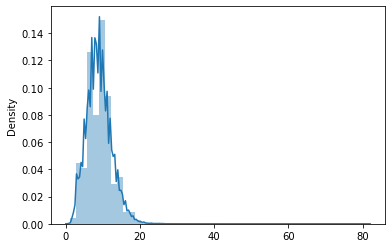

In [40]:
sns_plot = sns.distplot(len_tokens)
fig = sns_plot.get_figure()

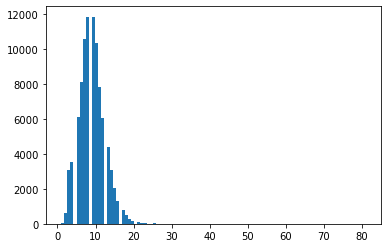

In [41]:
plt.hist(len_tokens, bins=100)
plt.show()

Чаще всего встречаются слова из 7-9 символов:

In [42]:
import collections
c = collections.Counter()
for word in len_tokens:
    c[word] += 1
c.most_common(3)

[(8, 11873), (9, 11863), (7, 10589)]

3.1 ТОР10 самых встечаемых слов-лемм:

In [43]:
#словарь вида токент-id
dictionary.token2id['добрый']

1

In [44]:
# частота встречаемости токенов во всех документах
dictionary.cfs[0]

173688

In [45]:
#отсортируем словарь по частоте встречаемости токенов (id-частота)
import operator
sorted_cfs = sorted(dictionary.cfs.items(), key=operator.itemgetter(1), reverse = True)

In [46]:
top_freq_keys = [k for k, v in sorted_cfs[:10]]
[dictionary[i] for i in top_freq_keys]

['банк',
 'карта',
 'это',
 'всё',
 'деньга',
 'я',
 'день',
 'не',
 'кредит',
 'который']

Самые часто встречаемые токены как и ожидалось относятся к стоп-словам

3.2 ТОР10 самых встечаемых слов-лемм без стоп-слов:

In [47]:
dictionary_no_sw = Dictionary(sentences_no_sw)

In [48]:
sorted_cfs_no_sw = sorted(dictionary_no_sw.cfs.items(), key=operator.itemgetter(1), reverse = True)

In [49]:
top_freq_keys_no_sw = [k for k, v in sorted_cfs_no_sw[:10]]
[dictionary_no_sw[i] for i in top_freq_keys_no_sw]

['банк',
 'карта',
 'это',
 'всё',
 'деньга',
 'я',
 'день',
 'не',
 'кредит',
 'который']

3.3 ТОР10 самых встечаемы слов (без лемматизации):

In [50]:
dictionary_no_lemm = Dictionary(sentences_no_lemm)

In [51]:
import operator
sorted_cfs_no_lemm = sorted(dictionary_no_lemm.cfs.items(), key=operator.itemgetter(1), reverse = True)

In [52]:
top_freq_keys_no_lemm = [k for k, v in sorted_cfs_no_lemm[:10]]
[dictionary_no_lemm[i] for i in top_freq_keys_no_lemm]

['в', 'и', 'не', 'на', 'что', 'я', 'с', 'по', 'мне', 'банка']

3.4 ТОР10 самых встечаемых слов - существительных (без лемматизации):

In [53]:
nouns_no_lemm = []
for k, v in sorted_cfs_no_lemm:
    if lemmatizer.parse(dictionary_no_lemm[k])[0].tag.POS == 'NOUN':
        nouns_no_lemm.append(dictionary_no_lemm[k])
    if len(nouns_no_lemm) == 10:
        break

In [54]:
nouns_no_lemm

['банка',
 'банк',
 'деньги',
 'карту',
 'карты',
 'кредит',
 'день',
 'раз',
 'банке',
 'заявление']

3.5 ТОР10 самых встечаемых слов - существительных (леммы):

In [55]:
nouns_lemm = []
for k, v in sorted_cfs:
    if lemmatizer.parse(dictionary[k])[0].tag.POS == 'NOUN':
        nouns_lemm.append(dictionary[k])
    if len(nouns_lemm) == 10:
        break

In [56]:
nouns_lemm

['банк',
 'карта',
 'деньга',
 'день',
 'кредит',
 'отделение',
 'счёт',
 'клиент',
 'сотрудник',
 'мочь']

# 4. Кривые Ципфа и Хипса


In [57]:
#Расчет рядов для кривой Ципфа
freq = []
rank = []
for i, (k, v) in enumerate(sorted_cfs):
    freq.append(v)
    rank.append(i)

In [58]:
dic = {} # словарь вида ключ- длина предложения; значение - массив из колиечества уникальных слов в предолжении (потом среднее)
prev = []
for text in sentences:
    if dic.get(len(text)) != None:
        prev = dic[len(text)]
        if len(set(text)) not in prev:
            prev.append(len(set(text)))
            dic[len(text)] = prev         
    else:
        dic[len(text)] = [len(set(text))]

In [59]:
#для для предложений определенной длинны есть разные варианты колиечества уникальных слов, берем среднее арифметическое по ним
dic_average = {}
for key, value in dic.items():
    dic_average[key] = round(mean(value))

In [60]:
sorted_dic_av = sorted(dic_average.items(), key=operator.itemgetter(0), reverse = False)

In [61]:
x = []
y = []
for slen, ulen in sorted_dic_av:
    x.append(slen)
    y.append(ulen)

<function matplotlib.pyplot.show(close=None, block=None)>

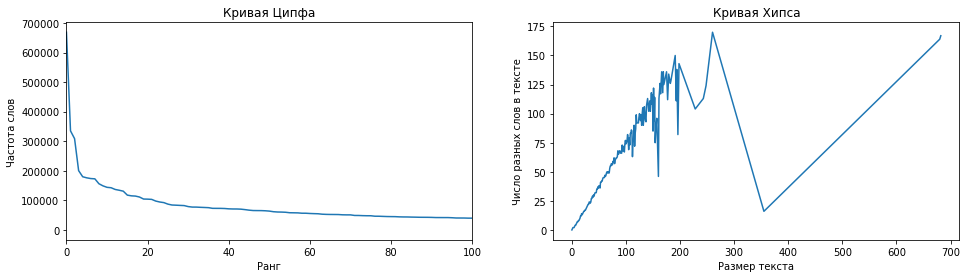

In [62]:
plt.figure(figsize=(16,4))

plt.subplot(121)
plt.plot(rank, freq)
plt.xlim(0, 100)
plt.title('Кривая Ципфа')
plt.xlabel('Ранг')
plt.ylabel('Частота слов')

plt.subplot(122)
plt.plot(x, y)
plt.title('Кривая Хипса')
plt.xlabel('Размер текста')
plt.ylabel('Число разных слов в тексте')

plt.show

# 5. Ответы на вопросы


5.1 какое слово встречается чаще, "сотрудник" или "клиент"?

In [63]:
#Найдем id слов в словаре
dictionary.token2id['сотрудник']

452

In [64]:
dictionary.token2id['клиент']

6

In [65]:
#Посмотрим как часто встречаются данные слова в предложениях
dictionary.cfs[dictionary.token2id['сотрудник']]

134168

In [66]:
dictionary.cfs[dictionary.token2id['клиент']]

136892

5.2 сколько раз встречается слова "мошенничество" и "доверие"?

In [67]:
#Найдем id слов в словаре
dictionary.token2id['мошенничество']

2466

In [68]:
dictionary.token2id['доверие']

1763

# 6. Ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [69]:
df5 = df[(df['rating_grade'] == 5.0) & (df['text'].isna() == False)].reset_index()[['text', 'rating_grade']]

In [70]:
df1 = df[(df['rating_grade'] == 1.0) & (df['text'].isna() == False)].reset_index()[['text', 'rating_grade']]

In [71]:
df5.head(5)

,text,rating_grade
0,Досрочно закрывали вклады перед отпуском. Жена...,5.0
1,"Хотел открыть вклад ""Доходный+"" под 19% год , ...",5.0
2,"Вчера, 3 июня, просидев в очереди более 3-х ча...",5.0
3,Сегодня открывал вклад в этом банке. Очередь б...,5.0
4,Моя история получения кредита в Ренессанс Кред...,5.0


In [72]:
#для всех отзывов с оценкой 5 проводим обратботку текста (ткоенизируем, удаляем лишние символы)
sentences5 = []  
print('Parsing sentences...')
for review in tqdm(df5['text']):
    sentences5.append(review_to_sentences(review, tokenizer, lemmatizer, True))

Parsing sentences...


100%|████████████████████████████████████████████████████████████████████████████| 14713/14713 [07:02<00:00, 34.84it/s]


In [73]:
sentences1 = []  
print('Parsing sentences...')
for review in tqdm(df1['text']):
    sentences1.append(review_to_sentences(review, tokenizer, lemmatizer, True))

Parsing sentences...


100%|████████████████████████████████████████████████████████████████████████████| 47387/47387 [28:00<00:00, 28.20it/s]


In [74]:
#в sentence5 разбито на предолжения. мы группируем по отзывам. т.е. если в отзыве несколько предолжений, то объединяем в одну строку
sent5 = []
for i, review in enumerate(sentences5):
    if len(review) > 1:
        res = []
        x = []
        x = [sentence for sentence in review if sentence != []]
        if x != []:
            res = list(concatenate(x))
    else:
        res = review[0]
    sent5.append(res)

In [75]:
sent1 = []
for i, review in enumerate(sentences1):
    if len(review) > 1:
        res = []
        x = []
        x = [sentence for sentence in review if sentence != []]
        if x != []:
            res = list(concatenate(x))
    else:
        res = review[0]
    sent1.append(res)

In [76]:
#заменим слово "банка" на "банк"
for isent,sentence in enumerate(sent5):
    for iword, word in enumerate(sentence):
        if word == 'банка':
            sent5[isent][iword] = 'банк'

In [77]:
for isent,sentence in enumerate(sent1):
    for iword, word in enumerate(sentence):
        if word == 'банка':
            sent1[isent][iword] = 'банк'

In [78]:
dictionary5 = Dictionary(sent5)
corpus5 = [dictionary5.doc2bow(text) for text in sent5]

In [79]:
dictionary1 = Dictionary(sent1)
corpus1 = [dictionary1.doc2bow(text) for text in sent1]

In [80]:
tfidf5 = TfidfModel(corpus5)
corpus_tfidf5 = tfidf5[corpus5]

In [81]:
def maxnIndSort(arr, dic, topn = 5):
    ww = [w for i, w in arr]
    ind = [i for i, w in arr]
    max_indices = sorted(range(len(ww)), key=lambda i: ww[i], reverse=True)[:topn]
    return [ind[i] for i in max_indices], [ww[i] for i in max_indices], [dic[ind[i]] for i in max_indices]

Ключевые слова для отзывов с рейтингом 5, полученных из модели tf-idf:



In [82]:
for i in range(20):
    print(maxnIndSort(corpus_tfidf5[i], dictionary5, topn = 5)[2])

['ленсовет', 'озерко', 'прикрыть', 'доступность', 'нести']
['доходный', 'вклад', 'взнос', 'снизить', 'первоначальный']
['июнь', 'выплата', 'выгнать', 'спасть', 'наплыть']
['какао', 'зав', 'наличие', 'туалет', 'затратить']
['страховка', 'гигабайт', 'ммс', 'сроккредит', 'евт']
['реструктуризация', 'неугодов', 'обрисовать', 'наталия', 'приглашение']
['депозит', 'располагаться', 'размещать', 'руководитель', 'подразделение']
['сетель', 'просрочить', 'регион', 'начислить', 'корректно']
['настолько', 'мудрец', 'отрада', 'шлёнский', 'ярина']
['георгий', 'тодуа', 'чужой', 'впадать', 'тимирязевский']
['тикета', 'кошелёк', 'просить', 'оферта', 'владение']
['плата', 'интерактивный', 'некачественный', 'поле', 'использование']
['камышин', 'доставка', 'заказать', 'консультантка', 'однажды']
['поменять', 'автовый', 'сравнение', 'паспорт', 'познаваться']
['навстеча', 'начислиться', 'наступление', 'должник', 'тянуть']
['балл', 'сбербанк', 'пароль', 'чек', 'идентификатор']
['переход', 'ссылка', 'шоколадн

In [83]:
df5['text'].head(1).values

array(['Досрочно закрывали вклады перед отпуском. Жена заказывала заранее, но забыла заказать на меня. Сотрудник банка (СПБ Ленсовета 89) Наталья не отказала мне, хотя сумма значительная. Работает быстро, профессионально. Ничего лишнего. Жаль, что прикрыли прием вкладов в офисе Озерки - доступность офиса для меня. Заметил, что и несут деньги во вклады и берут кредиты. Желаю успехов банку.'],
      dtype=object)

Ключевые слова для отзывов с рейтингом 1, полученных из модели tf-idf

In [86]:
tfidf1 = TfidfModel(corpus1)
corpus_tfidf1 = tfidf1[corpus1]

In [87]:
for i in range(20):
    print(maxnIndSort(corpus_tfidf1[i], dictionary1, topn = 5)[2])

['доллар', 'курс', 'долларовый', 'операционист', 'риторический']
['страховка', 'одобрить', 'страхование', 'самопроизвольно', 'сотрудник']
['менежер', 'вклад', 'неизменность', 'приказывать', 'винтик']
['капремонт', 'отчисление', 'внешний', 'лицевой', 'найти']
['квитанция', 'расписаться', 'положить', 'уверенность', 'чапаевск']
['бки', 'обновляться', 'тянуться', 'обновить', 'продолжение']
['привелигировать', 'клуб', 'евровой', 'евровую', 'операционистка']
['сытый', 'клерк', 'легко', 'репутация', 'заявлять']
['тихвинский', 'двадцатый', 'оправдываться', 'привозить', 'долларовый']
['терминал', 'симферопольский', 'стартовый', 'переключиться', 'рассмотрение']
['техносёл', 'своевременный', 'молча', 'отказ', 'письмо']
['терминал', 'вклад', 'пополнение', 'пополнить', 'тыс']
['платёжный', 'связанный', 'минимизация', 'установить', 'эквайер']
['развод', 'абсолютно', 'умирающий', 'средь', 'совдеповский']
['операционистка', 'заказать', 'вклад', 'раздвижной', 'средневысокий']
['отмена', 'карман', 'годо

In [88]:
df1['text'].head(1).values

array(['Открыт вклад и счет в USD. Плюс к этому есть зарплатная карта, в рублях, само собой. Сегодня пришел в указанное отделение с целью пополнить долларовый счёт на 700 USD.\xa0Дал операционисту паспорт, зарплатную карту (т.к. на окошке написано "приготовьте карту для подтверждения операции" или что-то подобное и в прошлый раз у меня ее потребовали) и сказал, что нужно положить деньги на ДОЛЛАРОВЫЙ счет.\xa0Операционист всё взяла, что-то делала-крутила-вертела, вставила карту в терминал, сказала "введите пин", я ввёл пин, получил в ответ чек, где было написано, что доллары были внесены.... на счёт КАРТЫ! в РУБЛЯХ! Вопрос банку №1, риторический:  Я не понимаю, кем нужно быть, чтобы сознательно проводить такие операции??? за углом, меньше чем через квартал, курс приёма валюты выше почти на рубль! Если я действительно хотел совершить такую "хитрую" операцию, мне было выгоднее сделать 100 шагов и "заработать" на этом около 700 рублей, после чего просто внести рубли на счёт карты в банком

# Часть 2. Тематическое моделирование

2.1 Тематические модели с разнм числом тем

In [89]:
sentences_scored = []  
print('Parsing sentences...')
for review in tqdm(df_score['text'][:30000]):
    sentences_scored.append(review_to_sentences(review, tokenizer, lemmatizer, True))

Parsing sentences...


100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [16:27<00:00, 30.39it/s]


In [90]:
sent_scored = []
for i, review in enumerate(sentences_scored):
    if len(review) > 1:
        res = []
        x = []
        x = [sentence for sentence in review if sentence != []]
        if x != []:
            res = list(concatenate(x))
    else:
        res = review[0]
    sent_scored.append(res)

In [91]:
for isent, sentence in enumerate(sent_scored):
    for iword, word in enumerate(sentence):
        if word == 'банка':
            sent_scored[isent][iword] = 'банк' 

In [92]:
dictionary_scored = Dictionary(sent_scored)

In [93]:
len(dictionary_scored.token2id)

43409

In [94]:
corpus_scored = [dictionary_scored.doc2bow(text) for text in sent_scored]

Тематическая модель с 10ю словами:

In [95]:
lda_model10 = LdaMulticore(corpus_scored, num_topics = 10, id2word = dictionary_scored, passes = 2, workers = 2)

In [96]:
lda_model10.print_topics(-1)

[(0,
  '0.035*"банк" + 0.021*"карта" + 0.014*"номер" + 0.012*"звонок" + 0.011*"это" + 0.010*"телефон" + 0.010*"смс" + 0.008*"звонить" + 0.008*"мой" + 0.007*"сотрудник"'),
 (1,
  '0.039*"карта" + 0.037*"банк" + 0.016*"счёт" + 0.008*"деньга" + 0.008*"который" + 0.008*"отделение" + 0.008*"это" + 0.007*"день" + 0.006*"клиент" + 0.006*"мой"'),
 (2,
  '0.030*"банк" + 0.014*"документ" + 0.013*"договор" + 0.009*"день" + 0.007*"который" + 0.007*"г" + 0.007*"мой" + 0.007*"это" + 0.006*"сотрудник" + 0.006*"год"'),
 (3,
  '0.033*"кредит" + 0.032*"банк" + 0.017*"сумма" + 0.012*"платёж" + 0.010*"договор" + 0.010*"сотрудник" + 0.008*"день" + 0.008*"это" + 0.008*"погашение" + 0.008*"кредитный"'),
 (4,
  '0.039*"карта" + 0.017*"банк" + 0.016*"отделение" + 0.011*"сказать" + 0.010*"это" + 0.009*"сбербанк" + 0.009*"день" + 0.009*"мой" + 0.008*"заявление" + 0.007*"прийти"'),
 (5,
  '0.040*"вклад" + 0.023*"банк" + 0.014*"деньга" + 0.013*"отделение" + 0.012*"открыть" + 0.012*"счёт" + 0.010*"очередь" + 0.009*

Тематическая модель с 20ю словами:

In [97]:
lda_model8 = LdaMulticore(corpus_scored, num_topics = 8, id2word = dictionary_scored, passes = 2, workers = 2)

In [98]:
lda_model8.print_topics(-1)

[(0,
  '0.029*"карта" + 0.018*"банк" + 0.018*"отделение" + 0.013*"день" + 0.012*"сказать" + 0.011*"сотрудник" + 0.009*"мой" + 0.008*"это" + 0.008*"который" + 0.008*"заявка"'),
 (1,
  '0.019*"банк" + 0.018*"г" + 0.015*"договор" + 0.015*"платёж" + 0.013*"сумма" + 0.012*"счёт" + 0.010*"сбербанк" + 0.009*"средство" + 0.009*"погашение" + 0.008*"кредит"'),
 (2,
  '0.040*"карта" + 0.023*"банк" + 0.017*"деньга" + 0.014*"банкомат" + 0.011*"день" + 0.010*"мой" + 0.010*"счёт" + 0.009*"заявление" + 0.007*"средство" + 0.007*"операция"'),
 (3,
  '0.027*"банк" + 0.013*"сотрудник" + 0.011*"мой" + 0.010*"карта" + 0.010*"офис" + 0.009*"клиент" + 0.009*"который" + 0.007*"заявление" + 0.007*"отделение" + 0.006*"это"'),
 (4,
  '0.038*"банк" + 0.027*"кредит" + 0.010*"сумма" + 0.009*"день" + 0.009*"договор" + 0.009*"сотрудник" + 0.009*"это" + 0.008*"кредитный" + 0.008*"который" + 0.008*"мой"'),
 (5,
  '0.039*"банк" + 0.021*"деньга" + 0.018*"счёт" + 0.011*"это" + 0.010*"день" + 0.008*"платёж" + 0.007*"сумма" 

Загрузим в модель LDA матрицу tf-idf, которая должна лучше выделить ключевые слова:

In [99]:
tfidf_scored = TfidfModel(corpus_scored)
corpus_scoredtfidf = tfidf_scored[corpus_scored]

In [100]:
lda_model10tfidf = LdaMulticore(corpus_scoredtfidf, num_topics = 8, id2word = dictionary_scored, passes = 2, workers = 2)

In [101]:
lda_model10tfidf.print_topics(-1)

[(0,
  '0.002*"вклад" + 0.002*"очередь" + 0.002*"отделение" + 0.002*"мособлбанк" + 0.001*"деньга" + 0.001*"офис" + 0.001*"карта" + 0.001*"работать" + 0.001*"кредит" + 0.001*"сбербанк"'),
 (1,
  '0.001*"раменский" + 0.001*"бегов" + 0.001*"рублёв" + 0.001*"карта" + 0.001*"выборгский" + 0.001*"птс" + 0.001*"суточный" + 0.001*"вклад" + 0.001*"неглинный" + 0.000*"стромынка"'),
 (2,
  '0.002*"пай" + 0.001*"пиф" + 0.001*"ивановский" + 0.001*"новокузнецк" + 0.001*"поляна" + 0.000*"недостача" + 0.000*"третьяковский" + 0.000*"нарый" + 0.000*"лант" + 0.000*"эос"'),
 (3,
  '0.001*"вклад" + 0.001*"балтика" + 0.001*"дельта" + 0.001*"мигом" + 0.001*"карта" + 0.001*"провайдер" + 0.001*"председатель" + 0.001*"деньга" + 0.001*"ростелеком" + 0.001*"астрахань"'),
 (4,
  '0.001*"мыло" + 0.001*"нештатный" + 0.001*"реорганизация" + 0.001*"камчатский" + 0.001*"дзержинск" + 0.001*"строгино" + 0.001*"липецкий" + 0.001*"миллиард" + 0.001*"карина" + 0.000*"мультиварка"'),
 (5,
  '0.001*"тыр" + 0.001*"чайковский" 

# Часть 3. Классификация текстов

In [102]:
size_sample = 14700
sample5 = sent5[:size_sample]
sample1 = sent1[:size_sample]
corpus_X = sample5 + sample1

In [103]:
y5 = [5 for i in range(len(sample5))]
y1 = [1 for i in range(len(sample1))]
y = y5 + y1

In [104]:
#пsent5 и sent1 уже токенизированы, но нам необходимо их опять склеить в строку, чтобы загрузить в BoW и tfidf
sent51_joined = []
sent51_joined = [' '.join(sentence) for sentence in corpus_X] 

In [105]:
vectorizerCV1 = CountVectorizer(ngram_range=(1, 1))
vectorizerCV2 = CountVectorizer(ngram_range=(2, 2))
vectorizerCV3 = CountVectorizer(ngram_range=(3, 3))
Xcv1 = vectorizerCV1.fit_transform(sent51_joined)
Xcv2 = vectorizerCV2.fit_transform(sent51_joined)
Xcv3 = vectorizerCV3.fit_transform(sent51_joined)

In [106]:
X_train_cv1, X_test_cv1, y_train_cv1, y_test_cv1 = train_test_split(Xcv1, y, test_size=0.2, random_state=42, stratify=y)

Классификация текстов

In [108]:
clf_cv1 = LogisticRegression(random_state=0).fit(X_train_cv1, y_train_cv1)


C:\DS\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [109]:
clf_cv1.score(X_test_cv1, y_test_cv1)

0.95578231292517

In [110]:
X_train_cv3, X_test_cv3, y_train_cv3, y_test_cv3 = train_test_split(Xcv3, y, test_size=0.2, random_state=42, stratify=y)
clf_cv3 = LogisticRegression(random_state=0).fit(X_train_cv3, y_train_cv3)
clf_cv3.score(X_test_cv3, y_test_cv3)

0.8530612244897959

Проверим резульаты для матрицы фичей, полученной с помощью tf-idf:

In [111]:
vectorizerTfidf1 = TfidfVectorizer(ngram_range=(1, 1))
vectorizerTfidf2 = TfidfVectorizer(ngram_range=(2, 2))
vectorizerTfidf3 = TfidfVectorizer(ngram_range=(3, 3))
X_tfidf1 = vectorizerTfidf1.fit_transform(sent51_joined)
X_tfidf2 = vectorizerTfidf2.fit_transform(sent51_joined)
X_tfidf3 = vectorizerTfidf3.fit_transform(sent51_joined)

In [112]:
X_train_tfidf1, X_test_tfidf1, y_train_tfidf1, y_test_tfidf1 = train_test_split(X_tfidf1, y, test_size=0.2, random_state=42, stratify=y)
clf_tfidf1 = LogisticRegression(random_state=0).fit(X_train_tfidf1, y_train_tfidf1)
clf_tfidf1.score(X_test_tfidf1, y_test_tfidf1)

0.9596938775510204

In [113]:
X_train_tfidf2, X_test_tfidf2, y_train_tfidf2, y_test_tfidf2 = train_test_split(X_tfidf2, y, test_size=0.2, random_state=42, stratify=y)
clf_tfidf2 = LogisticRegression(random_state=0).fit(X_train_tfidf2, y_train_tfidf2)
clf_tfidf2.score(X_test_tfidf2, y_test_tfidf2)

0.9280612244897959

In [114]:
vectorizerTfidf12 = TfidfVectorizer(ngram_range=(1, 2))
X_tfidf12 = vectorizerTfidf12.fit_transform(sent51_joined)
X_train_tfidf12, X_test_tfidf12, y_train_tfidf12, y_test_tfidf12 = train_test_split(X_tfidf12, y, test_size=0.2, random_state=42, stratify=y)
clf_tfidf12 = LogisticRegression(random_state=0).fit(X_train_tfidf12, y_train_tfidf12)
clf_tfidf12.score(X_test_tfidf12, y_test_tfidf12)

0.9545918367346938

Результат униграмм получился лучше, чем BoW, но не значительно. При ипоьлзовании би-,три-грамм результат становится хуже.

Сравнение качества решения задач

tf-idf и сингурялрное разложение

In [116]:
svd_ng1cmp10 = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
X_svd_ng1cmp10= svd_ng1cmp10.fit_transform(X_tfidf1)

In [117]:
X_svd_ng1cmp10.shape

(29400, 100)

In [118]:
X_tfidf1.shape

(29400, 45950)

In [119]:
X_train_svd10, X_test_svd10, y_train_svd10, y_test_svd10 = train_test_split(X_svd_ng1cmp10, y, test_size=0.2, random_state=42, stratify=y)
clf_svd10 = LogisticRegression(random_state=0).fit(X_train_svd10, y_train_svd10)
clf_svd10.score(X_test_svd10, y_test_svd10)

0.9493197278911565

In [120]:
res_svd = []
comp_iter = [10,30,60,100,200,300]
for ncomp in comp_iter:
    svd_ng1 = TruncatedSVD(n_components=ncomp, n_iter=7, random_state=42)
    X_svd_ng1 = svd_ng1.fit_transform(X_tfidf1)
    X_train_svd, X_test_svd, y_train_svd, y_test_svd = train_test_split(X_svd_ng1, y, test_size=0.2, random_state=42, stratify=y)
    clf_svd = LogisticRegression(random_state=0).fit(X_train_svd, y_train_svd)
    res_svd.append(clf_svd.score(X_test_svd, y_test_svd))

In [121]:
y_pred_svd = clf_svd.predict(X_test_svd)
target_names = ['Score 5', 'Score 1']
print(classification_report(y_test_svd, y_pred_svd))

              precision    recall  f1-score   support

           1       0.94      0.97      0.96      2940
           5       0.97      0.94      0.95      2940

    accuracy                           0.96      5880
   macro avg       0.96      0.96      0.96      5880
weighted avg       0.96      0.96      0.96      5880



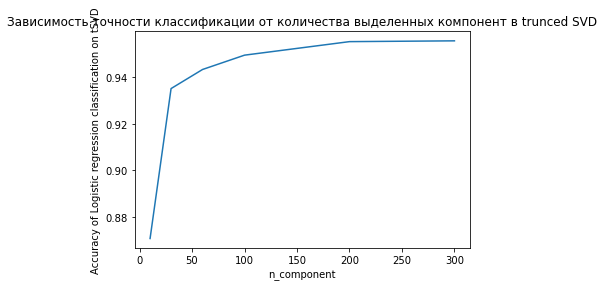

In [122]:
plt.title('Зависимость точности классификации от количества выделенных компонент в trunced SVD')
plt.xlabel('n_component')
plt.ylabel('Accuracy of Logistic regression classification on tSVD')
plt.plot(comp_iter, res_svd)
plt.show()

Вывод: уменьшив, количество фич с помощью сингурярного разложения truncated SVD, мы получили почти сходный результат, но модель будет работать быстрее. Уменьшение признаков с 46067 до 200 - в 230 раз. Пострадает интерпретируемость результатов. Увеличение количества итераций влияет на результат не значительно

tf-idf и тематические модели LDA

In [123]:
lda10 = LatentDirichletAllocation(n_components=10, random_state=42)
X_lda10 = lda10.fit_transform(X_tfidf1)

In [124]:
X_train_lda10, X_test_lda10, y_train_lda10, y_test_lda10 = train_test_split(X_lda10, y, test_size=0.2, random_state=42, stratify=y)
clf_lda10 = LogisticRegression(random_state=0).fit(X_train_lda10, y_train_lda10)
clf_lda10.score(X_test_lda10, y_test_lda10)

0.5491496598639456

In [125]:
res_lda = []
comp_iter = [10,30,60,100,200,300]
for ncomp in comp_iter:
    lda = LatentDirichletAllocation(n_components=ncomp, random_state=42)
    X_lda = lda.fit_transform(X_tfidf1)
    X_train_lda, X_test_lda, y_train_lda, y_test_lda = train_test_split(X_lda, y, test_size=0.2, random_state=42, stratify=y)
    clf_lda = LogisticRegression(random_state=0).fit(X_train_lda, y_train_lda)
    res_lda.append(clf_lda.score(X_test_lda, y_test_lda))

In [126]:
y_pred_lda = clf_lda.predict(X_test_lda)
target_names = ['Score 5', 'Score 1']
print(classification_report(y_test_lda, y_pred_lda))

              precision    recall  f1-score   support

           1       0.79      0.78      0.79      2940
           5       0.79      0.79      0.79      2940

    accuracy                           0.79      5880
   macro avg       0.79      0.79      0.79      5880
weighted avg       0.79      0.79      0.79      5880



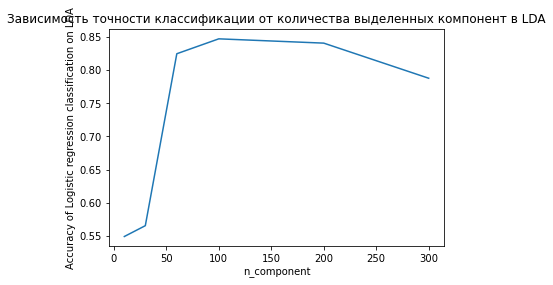

In [127]:
plt.title('Зависимость точности классификации от количества выделенных компонент в LDA')
plt.xlabel('n_component')
plt.ylabel('Accuracy of Logistic regression classification on LDA')
plt.plot(comp_iter, res_lda)
plt.show()

SVD работает гораздо быстрее, а резуьлтаты получаются лучше при прочих равных.